# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# install additional library if necessary
# %conda install -c conda-forge lightgbm progressbar py-xgboost -y

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
%%time

# load in the Azdias dataset
# finding 1: there are mixed data in column 18 and 19
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str', 19:'str'})

print('Shape of azdias: ', azdias.shape)
azdias.head()

Shape of azdias:  (891221, 366)
CPU times: user 11.7 s, sys: 1.15 s, total: 12.9 s
Wall time: 13.6 s


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## 0.1 Correct attributes' names

In [4]:
# load azdias value metadata. Note that the file format was converted from xlsx to csv
values = pd.read_csv("./data/DIAS_Attributes_Values_2017.csv", sep=',')

In [5]:
# finding 2: some attributes in the Azdias dataset do have their metadata
def get_unclear_attributes(azdias, values, display=False):
    unclear_attr = set(azdias.columns.values).difference(values['Attribute'])
    print("Number of unclear attributes in Azdias: {}".format(len(unclear_attr)))
    if display:
        print(unclear_attr)
        
    _attr = set(values['Attribute']).difference(azdias.columns.values)
    print("\nNumber of attributes NOT in Azdias (but have metadata info): {}".format(len(_attr)))
    if display:
        print(_attr)
    
    return unclear_attr

unclear_attr = get_unclear_attributes(azdias, values, display=True)

Number of unclear attributes in Azdias: 94
{'KBA13_BAUMAX', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_3', 'VK_DHT4A', 'D19_DIGIT_SERV', 'D19_BEKLEIDUNG_REST', 'RT_KEIN_ANREIZ', 'D19_BANKEN_DIREKT', 'KOMBIALTER', 'D19_SOZIALES', 'D19_SAMMELARTIKEL', 'UMFELD_JUNG', 'D19_HANDWERK', 'MOBI_RASTER', 'UNGLEICHENN_FLAG', 'D19_REISEN', 'KBA13_ANTG2', 'D19_RATGEBER', 'CJT_TYP_4', 'CJT_TYP_2', 'D19_FREIZEIT', 'AKT_DAT_KL', 'KBA13_GBZ', 'ALTER_KIND1', 'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_TELKO_MOBILE', 'D19_VERSI_DATUM', 'VHA', 'ALTER_KIND4', 'KBA13_ANTG1', 'D19_HAUS_DEKO', 'D19_WEIN_FEINKOST', 'CJT_TYP_6', 'EXTSEL992', 'KONSUMZELLE', 'DSL_FLAG', 'ALTERSKATEGORIE_FEIN', 'EINGEFUEGT_AM', 'D19_SCHUHE', 'D19_BANKEN_GROSS', 'D19_BUCH_CD', 'D19_BANKEN_REST', 'EINGEZOGENAM_HH_JAHR', 'KBA13_HHZ', 'HH_DELTA_FLAG', 'D19_TELKO_ONLINE_QUOTE_12', 'RT_SCHNAEPPCHEN', 'CJT_KATALOGNUTZER', 'D19_VOLLSORTIMENT', 'ARBEIT', 'VERDICHTUNGSRAUM', 'D19_TECHNIK', 'D19_BEKLEIDUNG_GEH', 'CJT_TYP_5', 'ALTER_KIND3', 'A

In [6]:
# some attributes have similar name, for example D19_BEKLEIDUNG_GEH and D19_BEKLEIDUNG_GEH_RZ
# we guess that they are correct name of attribute
_attrs = set(values['Attribute']).difference(azdias.columns.values)
_attrs = map(lambda x: x.replace("_RZ",""), _attrs)

rz_attr = unclear_attr.intersection(_attrs)
print("Number of re-assigned attributes: {}\n".format(len(rz_attr)))

# modify azdias value metadata
rz_attr_with_RZ = list(map(lambda x: x + "_RZ", rz_attr))
values['Attribute'] = values['Attribute'].apply(lambda x: x.replace("_RZ","") if x in rz_attr_with_RZ else x)

# re-compute unclear_attr
unclear_attr = get_unclear_attributes(azdias, values, display=True)

Number of re-assigned attributes: 33

Number of unclear attributes in Azdias: 61
{'KBA13_BAUMAX', 'ANZ_STATISTISCHE_HAUSHALTE', 'HH_DELTA_FLAG', 'CJT_TYP_3', 'RT_SCHNAEPPCHEN', 'CJT_KATALOGNUTZER', 'VK_DHT4A', 'D19_TELKO_ONLINE_QUOTE_12', 'VERDICHTUNGSRAUM', 'ARBEIT', 'RT_KEIN_ANREIZ', 'KOMBIALTER', 'CJT_TYP_5', 'D19_SOZIALES', 'ALTER_KIND3', 'ANZ_KINDER', 'ALTER_KIND2', 'UMFELD_JUNG', 'MOBI_RASTER', 'UMFELD_ALT', 'FIRMENDICHTE', 'KBA13_CCM_1401_2500', 'UNGLEICHENN_FLAG', 'GEMEINDETYP', 'CAMEO_INTL_2015', 'D19_KONSUMTYP_MAX', 'KBA13_ANTG2', 'CJT_TYP_4', 'LNR', 'KBA13_KMH_210', 'RT_UEBERGROESSE', 'SOHO_KZ', 'CJT_TYP_2', 'AKT_DAT_KL', 'KBA13_GBZ', 'ALTER_KIND1', 'STRUKTURTYP', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'CJT_TYP_1', 'VK_DISTANZ', 'D19_VERSI_DATUM', 'VK_ZG11', 'VHA', 'ALTER_KIND4', 'KBA13_ANTG1', 'KK_KUNDENTYP', 'VHN', 'CJT_TYP_6', 'EXTSEL992', 'KONSUMZELLE', 'DSL_FLAG', 'ALTERSKATEGORIE_FEIN', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA13_ANTG4', 'EINGEFUEGT_AM', 'KBA13_A

## 0.2 Handle Unknown value

Ideally, the dataset should not contain unknown values because those values damage the clustering process. However, it is difficult to collect such datasets since it may contain sensitive information. In the Azdias dataset, an unknown value can be:
* np.NaN in the dataset
* unknown value listed in the Azdias value metadata
* not given (e.g., a value of 0 not described in the metadata but exist in the dataset)

### 0.2.1 Get unknown values

In [7]:
def create_unknown_value_dict(azdias, values, unclear_attr):
    '''
    Create the dictionary of attributes with values being an array of unknown values
    '''
    
    dictionary = {}
    for key in set(values['Attribute']):
        dictionary[key] = []
        
    # given the defined attributes, get the Unknown value
    unknown_value = values[values['Meaning'].isin(["unknown","unknown / no main age detectable",
                                                   "no transactions known", "no transaction known"])]
    for _, row in unknown_value.iterrows():
        key = row['Attribute']
        dictionary[key] = [x.strip() for x in row['Value'].split(",")]
        
    ## for unclear attributes:
    
    # CJT is stand for Customer-Journey-Typology
    dictionary['CJT_KATALOGNUTZER'] = dictionary['CJT_TYP_1'] = dictionary['CJT_TYP_2'] = \
    dictionary['CJT_TYP_3'] = dictionary['CJT_TYP_4'] = dictionary['CJT_TYP_5'] = dictionary['CJT_TYP_6'] = []
    
    # D19 is for transaction activity
    dictionary['D19_BUCH_CD'] = dictionary['D19_BUCH_RZ']
    dictionary['D19_KONSUMTYP_MAX'] = dictionary['D19_SOZIALES'] = dictionary['D19_TELKO_ONLINE_QUOTE_12'] = []
    dictionary['D19_VERSI_DATUM'] =  dictionary['D19_VERSAND_DATUM']
    dictionary['D19_VERSI_OFFLINE_DATUM'] = dictionary['D19_VERSAND_OFFLINE_DATUM']    
    dictionary['D19_VERSI_ONLINE_DATUM'] = dictionary['D19_VERSAND_ONLINE_DATUM'] 
    dictionary['D19_VERSI_ONLINE_QUOTE_12'] = dictionary['D19_VERSAND_ONLINE_QUOTE_12']
    
    # KBA13 is for car sharing
    dictionary['KBA13_ANTG1'] = dictionary['KBA05_ANTG1']
    dictionary['KBA13_ANTG2'] = dictionary['KBA05_ANTG2']
    dictionary['KBA13_ANTG3'] = dictionary['KBA05_ANTG3']
    dictionary['KBA13_ANTG4'] = dictionary['KBA05_ANTG4']
    dictionary['KBA13_BAUMAX'] = dictionary['KBA05_BAUMAX']
    dictionary['KBA13_GBZ'] = dictionary['KBA05_GBZ']
    dictionary['KBA13_CCM_1401_2500'] = dictionary['KBA13_CCM_1400_2500'] 
    dictionary['KBA13_HHZ'] = dictionary['PLZ8_HHZ']
    dictionary['KBA13_KMH_210'] = dictionary['KBA13_KMH_180']
    
    # special attribute
    dictionary['CAMEO_INTL_2015'] = ["XX"]
    
    # Other attributes (in unclear_attr) which have no info of Unknown value -> set to [] (default setting)
    
    # NOTE: later in Feature engineering, we found some unknown values not in dictationary
    dictionary['CAMEO_DEUG_2015'] = ["X"]
    dictionary['CAMEO_DEU_2015'] =["XX"]
    dictionary['GEBURTSJAHR'] = ["0"] # birthday
    
    return dictionary

In [8]:
unknown_value_dict = create_unknown_value_dict(azdias, values, unclear_attr)
# print(unknown_value_dict)

### 0.2.3 Convert all type of Unknown values into a single value of np.NaN 

In [9]:
def count_unknown_value_by_column(azdias):
    '''
    Calculates number of np.NaN in each columns of dataset azdias
    '''       
    unknown_value_array = []
    for col in azdias.columns:
        try:
            unknown_value_array.append(azdias[col].isnull().value_counts()[1])
        except:
            unknown_value_array.append(0)
    return unknown_value_array

In [10]:
# count unknown values before converting
original_unknown_values = count_unknown_value_by_column(azdias)
# print(original_unknown_values)

In [11]:
def convert_unknown_value_to_nan(df, unknown_value_dict, slient = False):
    '''
    Replaces given keys from unknown_value_dict to NaN in dataframe
    
    Input:
        df (DataFrame): Dataset for which keys to np.nan need to be converted
        unknown_value_dict: dictionary of attributes with keys that needs to be converted to NaN
        slient: True if print out information (for debug purpose)
    '''
    for attribute in unknown_value_dict:
        if attribute in df.columns:       
            for item in unknown_value_dict[attribute]:
                
                # process special unknown values
                if item == 'X' or item == 'XX':
                    value = str(item)
                elif item == '0.0':
                    value = int(0)
                else:
                    value = int(item)
                    
                df[attribute].replace(value, np.NaN, inplace=True)
                if type(value) is int:
                    df[attribute].replace(float(value), np.NaN, inplace=True)
        elif slient == False:
            print("Attribute {} is not available in Azdias.".format(attribute))

In [12]:
convert_unknown_value_to_nan(azdias, unknown_value_dict)

Attribute D19_BUCH_RZ is not available in Azdias.
Attribute CAMEO_DEUINTL_2015 is not available in Azdias.
Attribute WACHSTUMSGEBIET_NB is not available in Azdias.
Attribute HAUSHALTSSTRUKTUR is not available in Azdias.
Attribute SOHO_FLAG is not available in Azdias.
Attribute BIP_FLAG is not available in Azdias.
Attribute KBA13_CCM_1400_2500 is not available in Azdias.
Attribute D19_KK_KUNDENTYP is not available in Azdias.
Attribute GEOSCORE_KLS7 is not available in Azdias.


In [13]:
# count unknown values after converting
final_unknown_values = count_unknown_value_by_column(azdias)
# print(final_unknown_values)

In [14]:
n_records = azdias.shape[0] # number or records/rows

report = pd.DataFrame(data=azdias.columns, columns=["Attribute"])
report['Original'] = original_unknown_values
report['Original'] /= n_records
report['Final'] = final_unknown_values 
report['Final'] /= n_records
report = report.sort_values(by='Final', ascending=False)
print(report.round(2)[:10])

                    Attribute  Original  Final
7                 ALTER_KIND4      1.00   1.00
349                  TITEL_KZ      0.08   1.00
6                 ALTER_KIND3      0.99   0.99
91     D19_VERSI_ONLINE_DATUM      0.00   0.99
76     D19_TELKO_ONLINE_DATUM      0.00   0.99
33           D19_BANKEN_LOKAL      0.00   0.98
34   D19_BANKEN_OFFLINE_DATUM      0.00   0.98
5                 ALTER_KIND2      0.97   0.97
90    D19_VERSI_OFFLINE_DATUM      0.00   0.96
71           D19_TELKO_ANZ_12      0.00   0.96


### 0.2.3 Drop columns/attributes that have a lot of NaN

Distribution of the number of unknown values in AZDIAS dataset


Text(0.5, 1.0, 'Distribution of Attribute')

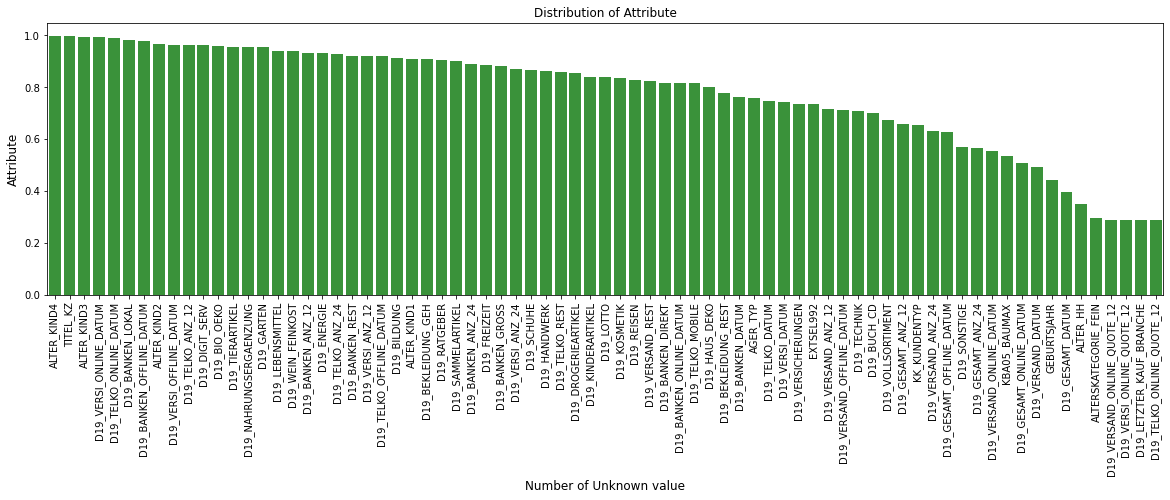

In [15]:
print("Distribution of the number of unknown values in AZDIAS dataset")
n_columns = 75 # number of attributes to display
fig = plt.figure(figsize=(20,5))

ax = sns.barplot(report['Attribute'][0:n_columns], report['Final'], color = sns.color_palette()[2])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Number of Unknown value', size='large')
ax.set_ylabel('Attribute', size='large');
ax.set_title('Distribution of Attribute', size='large')

In [16]:
MAX_NUMBER_OF_UNKNOWN_VALUE = 0.3
print('Max number of unknown values in a column/attribute: {} \n'.format(MAX_NUMBER_OF_UNKNOWN_VALUE * n_records))

deleted_rows = report[report['Final'] > MAX_NUMBER_OF_UNKNOWN_VALUE]
deleted_attr = list(deleted_rows['Attribute'])
print('Number of removed columns: ', len(deleted_attr))
print(sorted(deleted_attr))

Max number of unknown values in a column/attribute: 267366.3 

Number of removed columns:  70
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',

In [17]:
azdias = azdias.drop(deleted_attr, axis=1)
print('Number of remaining columns/attributes: ', azdias.shape[1])

Number of remaining columns/attributes:  296


### 0.2.4 Drop rows/records that have a lot of NaN

Text(0.5, 1.0, 'Distribution of unknown values per row')

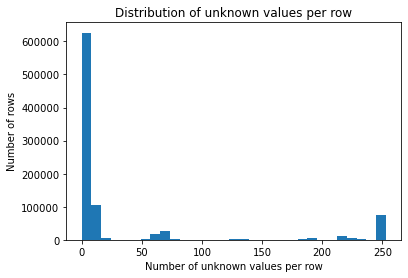

In [18]:
# How much data is unknown in each row of the dataset?
azdias['n_unknown'] = azdias.isnull().sum(axis=1)

ax = azdias["n_unknown"].plot(kind='hist', bins=31)
ax.set_xlabel("Number of unknown values per row")
ax.set_ylabel("Number of rows")
ax.set_title('Distribution of unknown values per row', size='large')

In [19]:
MAX_NUMBER_OF_UNKNOWN_VALUE_PER_ROW = azdias.shape[1] * 0.3
print('Max number of unknown values in a row/record: {} \n'.format(MAX_NUMBER_OF_UNKNOWN_VALUE_PER_ROW))

n_rows = azdias.shape[0]
indexs = azdias[azdias['n_unknown'] > MAX_NUMBER_OF_UNKNOWN_VALUE_PER_ROW].index
azdias.drop(indexs, inplace=True)
azdias.drop(['n_unknown'], axis=1, inplace=True)

print('New dataset shape: {}'.format(azdias.shape))
print('The new dataset contains {}% of the original amount of rows'.format(int(azdias.shape[0] / n_rows * 100)))

Max number of unknown values in a row/record: 89.1 

New dataset shape: (785302, 296)
The new dataset contains 88% of the original amount of rows


## 0.3 Feature (attribute) engineering

### 0.3.1 Get value information of attributes in the Azdias dataset

In [20]:
def get_existing_value_info(azdias, values):
    attributes = {}
    target_attr = set(values["Attribute"]).intersection(azdias.columns.values)
    attributes['Name'] = sorted(list(target_attr))
    
    n_value_column = []
    value_column = []
    unknown_value_column = []
    for attribute in attributes['Name']:
        texts = values[values['Attribute'] == attribute]['Value']
        
        value_set = set()
        for text in texts:
            value_set = value_set.union([x.strip() for x in text.split(",")])

        unknown_value_list = unknown_value_dict[attribute]
        unknown_value_string = ",".join(unknown_value_list)
        unknown_value_column.append(unknown_value_string)
        
        value_list = [v for v in value_set if v not in unknown_value_list]
        n_value_column.append(len(value_list))
            
        value_string = ",".join(sorted(value_list))
        value_column.append(value_string)
        
    attributes['n_values'] = n_value_column
    attributes['Values'] = value_column
    attributes['Unknown_value'] = unknown_value_column
    return attributes

In [21]:
### Get existing value-information from the Azdias dataset
attributes = get_existing_value_info(azdias, values)
print('Number of attribute info: ', len(attributes['Name']), '/', len(azdias.columns.values))

Number of attribute info:  245 / 296


In [22]:
### Checking if attributes['Values'] cover all values in `azdias`, we found that
###  1. CAMEO_DEUG_2015 has string type -> convert to float
###  2. CAMEO_DEU_2015 has special values -> need engineering (will inverstigate later)
###  3. KBA05_MODTEMP has a different value of 6 -> drop this attribute
###  5. OST_WEST_KZ is a binary value but different representation -> convert to [0,1]
###  6. Some unknown values should be added into the dictationary (the last three attributes are moved 
###  to create_unknown_value_dict() so we do not see the result here
###     LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, ORTSGR_KLS9 should have 0.0
###     GEBURTSJAHR has unknown value of [0] (not year)
###     CAMEO_DEUG_2015 has unknown value of ['X']
###     CAMEO_DEU_2015 has unknown value of ['XX']
### These above findings are used to clean data in the next part

_report = pd.DataFrame(data=attributes)

for _, row in _report.iterrows():
    attribute = row['Name']
    
    # handle the numberic type
    if row['Values'] == '?':
        value_set = set(azdias[azdias[attribute].notnull()][attribute])
        n_values = min(len(value_set), 15)
        print('---', attribute, 'has no unknown value --> check again')
        print('  Actual: ', list(value_set)[:n_values])
        continue
    
    # get values from metadata
    value_set_info = row['Values'].split(",")
    try:
        value_set_info = set([float(x) for x in value_set_info])
    except:
        value_set_info = set(value_set_info)
        print('>>>', attribute, 'is not in float type')
        print('  Metadata: ', value_set_info)
        
    # get values from actual dataset
    value_set = set(azdias[azdias[attribute].notnull()][attribute])
    if not value_set.issubset(value_set_info):
        print('+++', attribute)
        n_values = min(len(value_set), 15)
        print('  Actual:   ', list(value_set)[:n_values])
        print('  Metadata: ', list(value_set_info)[:n_values])
        
_report = None

--- ANZ_HAUSHALTE_AKTIV has no unknown value --> check again
  Actual:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
--- ANZ_HH_TITEL has no unknown value --> check again
  Actual:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
--- ANZ_PERSONEN has no unknown value --> check again
  Actual:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
--- ANZ_TITEL has no unknown value --> check again
  Actual:  [0.0, 1.0, 2.0, 3.0, 4.0]
+++ CAMEO_DEUG_2015
  Actual:    ['2', '5', '6', '3', '8', '4', '1', '9', '7']
  Metadata:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
>>> CAMEO_DEU_2015 is not in float type
  Metadata:  {'6E', '7E', '7C', '7B', '8D', '9C', '9B', '5C', '1C', '2B', '4A', '4D', '1B', '1D', '5F', '6B', '6C', '5A', '5B', '3B', '8C', '3A', '5D', '4C', '7A', '6F', '5E', '9E', '9A', '6A', '4E', '9D', '2C', '3D', '3C', '1E', '2A', '8A', '7D', '8B', '2D', '1A', '4B', '6D'}
+++ KBA05_M

In [23]:
### Insert data of unclear attributes into dataframe 'attributes'
different_attr = set(azdias.columns.values).difference(values['Attribute'])

for attribute in different_attr:
    attributes['Name'].append(attribute)
        
    value_set = set(azdias[azdias[attribute].notnull()][attribute])
    value_strings = [str(v) for v in value_set]
    attributes['n_values'].append(len(value_strings))

    value_strings = value_strings[:20] if len(value_strings) > 20 else value_strings
    value_string = ",".join(value_strings)
    attributes['Values'].append(value_string)
    
    attributes['Unknown_value'].append("")
    
print('Number of attribute: ', len(attributes['Name']), '/', len(azdias.columns.values))

Number of attribute:  296 / 296


### 0.3.2 Manually check detailed info and decide the type 

Based on the above findings, we create a file name **features-final.csv** to store the unknown/known values and information of each dataset and use it for fast processing on multiple dataframe  

In [24]:
### Load the additional info and store into features-before-engineering.csv
infos = pd.read_csv('data/DIAS_Information_Levels_Attributes_2017.csv', sep=',')
references = infos['Attribute'].values

info_column = []
for attribute in attributes['Name']:
    if attribute in references:
        text = str(infos[infos['Attribute'] == attribute]['Info'].values[0])
    else:
        text = ""
    info_column.append(text)
attributes['Info'] = info_column

report = pd.DataFrame(data=attributes)
report.to_csv("data/features-before-engineering.csv", index=False)

In [25]:
### after creating features-final.csv, read this file
features = pd.read_csv('data/features-final.csv', sep=',')
features['Type'].value_counts()

ordinal        241
categorical     27
numberic        11
binary          10
-                4
mixed            3
Name: Type, dtype: int64

### 0.3.3 Clean data

1. Set of unknown values
  - LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, ORTSGR_KLS9 columns in dataset do not contain value of 0 -> guess it is an unknonwn value, manually add into __feature-final.csv__
2. Dropped columns
  - LNR is ID column not feature
  - KBA05_MODTEMP column contain a value of 6 -> cannot understand
  - GEMEINDETYP, D19_KONSUMTYP_MAX, KOMBIALTER, VERDICHTUNGSRAUM are difficult to understand
  - CAMEO_DEU_2015 and CAMEO_DEUG_2015 are both describing New German CAMEO Typology but at different scales. Since CAMEO_DEU_2015 contains 44 categories, I've decided to keep CAMEO_DEUG_2015 only and drop CAMEO_DEU_2015.
  - Similar to CAMEO_DEUG_2015, I've decided to keep LP_LEBENSPHASE_GROB and remove LP_LEBENSPHASE_FEIN.
3. Data type convertion
  - CAMEO_DEUG_2015 has string type -> convert to float
  - OST_WEST_KZ is a binary value but different representation -> convert to [0,1]
  - EINGEFUEGT_AM is in date-time format -> can convert to year
4. Column seperation
  - CAMEO_INTL_2015 contains mixed data -> separate into WEALTH and LIFE_AGE
  - PRAEGENDE_JUGENDJAHRE contains mixed data -> separate into MOVEMENT and GENERATION_DECADE
  - PLZ8_BAUMAX contains mixed data but we can treat this feature as categorical 

In [26]:
### Correct the set of unknown values and Re-check the number per column

# At the first running, we found that the number of NaN for GEBURTSJAHR is about 38%. Other attributes remain unchanged.
# Since we decided to move setting of GEBURTSJAHR to create_unknown_value_dict() so it is deleted in Part 0.2

incorrect_unknown_columns = ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB',    
                             'ORTSGR_KLS9'] # LP_LEBENSPHASE_FEIN and GEBURTSJAHR are decided to drop

def print_column_info(azdias, columns):
    for attribute in columns:
        num = azdias[attribute].isnull().sum()
        print(f'>>> Number of NaN: {num} of {attribute} account for {int(num / azdias.shape[0] * 100)}%')
        print('Set: ', unknown_value_dict[attribute])
        print('Actual: ',  set(azdias[azdias[attribute].notnull()][attribute]))

print("Number of unknown values BEFORE adding new unknown value")
print_column_info(azdias, incorrect_unknown_columns)
    
for attribute in incorrect_unknown_columns:
    unknown_value_dict[attribute].append('0')
    azdias[attribute].replace([0], [np.nan], inplace=True)
    azdias[attribute].replace([0.0], [np.nan], inplace=True)
    
print("-------------------------------------------------------") 
print("Number of unknown values AFTER adding new unknown value")
print_column_info(azdias, incorrect_unknown_columns)

Number of unknown values BEFORE adding new unknown value
>>> Number of NaN: 4572 of LP_FAMILIE_FEIN account for 0%
Set:  []
Actual:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0}
>>> Number of NaN: 4572 of LP_FAMILIE_GROB account for 0%
Set:  []
Actual:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
>>> Number of NaN: 4572 of LP_LEBENSPHASE_GROB account for 0%
Set:  []
Actual:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0}
>>> Number of NaN: 4026 of ORTSGR_KLS9 account for 0%
Set:  ['-1']
Actual:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}
-------------------------------------------------------
Number of unknown values AFTER adding new unknown value
>>> Number of NaN: 30890 of LP_FAMILIE_FEIN account for 3%
Set:  ['0']
Actual:  {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0}
>>> Number of NaN: 30890 of LP_FAMILIE_GROB account for 3%
Set:  ['0']
Actual:  {1.0, 2.0, 3.0, 4.0, 5.0}
>>> Number of NaN: 46457 of LP_LEBENSPHASE_GROB account for 5%
Se

In [27]:
def clean_data(df):
    print("Drop columns")
    deleted_attributes = ["LNR", 
                          "KBA05_MODTEMP", "GEMEINDETYP", "D19_KONSUMTYP_MAX", "KOMBIALTER", "VERDICHTUNGSRAUM",
                          "CAMEO_DEU_2015", "LP_LEBENSPHASE_FEIN"]
    df.drop(deleted_attributes, axis=1, inplace=True)

    print("Convert CAMEO_DEUG_2015 to float")
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].astype(float)

    print("Re-encode OST_WEST_KZ")
    df['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)

    print("Change EINGEFUEGT_AM to year format")
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].dt.year
    
    print("Saperate PRAEGENDE_JUGENDJAHRE into MOVEMENT and GENERATION_DECADE")
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                           [np.nan,np.nan,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2], inplace=True) 
    df['GENERATION_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['GENERATION_DECADE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                                    [np.nan,np.nan,4,4,5,5,6,6,6,7,7,8,8,8,8,9,9], inplace=True) 
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

    print("Saperate CAMEO_INTL_2015 into WEALTH and LIFE_AGE")
    df['WEALTH'] = df['CAMEO_INTL_2015'].str[:1].astype(float)
    df['LIFE_AGE'] = df['CAMEO_INTL_2015'].str[1:2].astype(float)
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    
    return df

In [28]:
azdias = clean_data(azdias)
print(azdias.shape)

Drop columns
Convert CAMEO_DEUG_2015 to float
Re-encode OST_WEST_KZ
Change EINGEFUEGT_AM to year format
Saperate PRAEGENDE_JUGENDJAHRE into MOVEMENT and GENERATION_DECADE
Saperate CAMEO_INTL_2015 into WEALTH and LIFE_AGE
(785302, 290)


### 0.3.4 Impute  data

In [30]:
def impute(df):
    '''
    Imputes the most frequent value per column.
    Input:
        df (dataframe) - dataframe to be used.
    Output:
        df_copy (dataframe) - imputed dataframe.
    '''
    df_copy = df.copy()

    cnter = 0
    bar = progressbar.ProgressBar(maxval = df_copy.shape[1] + 1, 
                                  widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    bar.start()

    for col in df_copy.columns[df_copy.isnull().any()]:
        cnter += 1
        bar.update(cnter)
        most_freq_value = df_copy.groupby([col])[col].count().sort_values(ascending=False).index[0]
        df_copy[col].fillna(most_freq_value, inplace=True)

    bar.finish()

    return df_copy

In [31]:
azdias_imputed = impute(azdias)
print(azdias_imputed.shape)

(785302, 290)


### 0.3.4. Re-encode categorical features

In [32]:
cat_features = list(features[(features['Type'] == "categorical") & (features['Action'] != "drop")]['Name'])
print('Categorical features:', cat_features)

Categorical features: ['WOHNLAGE', 'ZABEOTYP', 'CJT_KATALOGNUTZER', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_HERSTTEMP', 'STRUKTURTYP', 'LP_LEBENSPHASE_GROB', 'CJT_GESAMTTYP', 'SHOPPER_TYP', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'KBA05_MAXHERST', 'PLZ8_BAUMAX', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'VHA', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'KBA05_MAXSEG', 'LP_STATUS_GROB', 'NATIONALITAET_KZ']


In [33]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [34]:
def fit_transform(df, columns, OH_encoder):
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[columns]))
    OH_cols.index = df.index
    OH_cols.columns = OH_encoder.get_feature_names(columns)
    num_df = df.drop(columns, axis=1)
    return pd.concat([num_df, OH_cols], axis=1)
    
def transform(df, columns, OH_encoder):
    OH_cols = pd.DataFrame(OH_encoder.transform(df[columns]))
    OH_cols.index = df.index
    OH_cols.columns = OH_encoder.get_feature_names(columns)
    num_df = df.drop(columns, axis=1)
    return pd.concat([num_df, OH_cols], axis=1)

In [35]:
# cleaned_azdias = pd.get_dummies(azdias_imputed, columns=cat_features)
cleaned_azdias = fit_transform(azdias_imputed, cat_features, OH_encoder)
print(cleaned_azdias.shape)

(785302, 452)


## 0.4 Repeat with customers

__IMPORTANT NOTE:__

* To avoid memory issue, we start **reading the dataset from beginning** and only execute the neccessry part
* Due to the lack of memory and computation, we restore result after processing
* Since we re-arrange the order of processing, the length of cleaned_azdias slightly changes from 785302 to 785300

In [36]:
def clean_dataset(orginal_df, new_attr_of_customers = [], drop_rows = True):
    print('===== Drop extra columns =====')
    df = orginal_df.drop(new_attr_of_customers, axis=1)
    
    print('======== Drop columns ========')
    deleted_attrs= ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
                    'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 
                    'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 
                    'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 
                    'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 
                    'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 
                    'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 
                    'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 
                    'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 
                    'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM', 
                    'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 
                    'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 
                    'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 
                    'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 
                    'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
    deleted_attrs.extend(["LNR", 
                          "KBA05_MODTEMP", "GEMEINDETYP", "D19_KONSUMTYP_MAX", "KOMBIALTER", "VERDICHTUNGSRAUM",
                          "CAMEO_DEU_2015", "LP_LEBENSPHASE_FEIN"])
    df.drop(deleted_attrs, axis=1, inplace=True)
    print(df.shape)
    
    print('==== Handle Unknown value ====')
    unknown_value_dict = {}
    feature_info = pd.read_csv('data/features-final.csv', sep=',')
    for _, info in feature_info.iterrows():
        if not pd.isnull(info['Unknown_value']):
            feature = info['Name']
            values = info['Unknown_value'].split(",")
            unknown_value_dict[feature] = values
    convert_unknown_value_to_nan(df, unknown_value_dict, slient = True)
    print(df.shape)
    
    print('======== Modify data =========')
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].astype(float)
    
    df['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].dt.year
    
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                                                         [np.nan,np.nan,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2]) 
    df['GENERATION_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                                                                  [np.nan,np.nan,4,4,5,5,6,6,6,7,7,8,8,8,8,9,9]) 
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

    df['WEALTH'] = df['CAMEO_INTL_2015'].str[:1]
    df['WEALTH'] = df['WEALTH'].apply(lambda x: float(x) if x != 'X' else np.NaN)
    df['LIFE_AGE'] = df['CAMEO_INTL_2015'].str[1:2]
    df['LIFE_AGE'] = df['LIFE_AGE'].apply(lambda x: float(x) if x != 'X' else np.NaN)
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    print(df.shape)

    if drop_rows:
        print('========== Drop rows =========')
        MAX_NUMBER_OF_UNKNOWN_VALUE_PER_ROW = 89.1 # azdias.shape[1] * 0.3
        df['n_unknown'] = df.isnull().sum(axis=1)
        row_indexs = df[df['n_unknown'] > MAX_NUMBER_OF_UNKNOWN_VALUE_PER_ROW].index
        df.drop(row_indexs, inplace=True)
        df.drop(['n_unknown'], axis=1, inplace=True)
        print(df.shape)
    
    print('=========== Impute ===========')
    df = impute(df)
    print(df.shape)
    
    return df    

In [37]:
%%time

# load in the data from beginning
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})

CPU times: user 11.3 s, sys: 1.74 s, total: 13 s
Wall time: 15.3 s


In [38]:
# require 2 functions: convert_unknown_value_to_nan(), impute()
# the length is 785300 because we execute the pre-processing in a different order, 
# and the threshold of 30% provides different results. However, it does not affect much
cleaned_azdias = clean_dataset(azdias)

===== Drop extra columns =====
======== Drop columns ========
(891221, 288)
==== Handle Unknown value ====
(891221, 288)
======== Modify data =========
(891221, 290)
========== Drop rows =========
(785300, 290)
=========== Impute ===========


(785300, 290)


In [39]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_features = ['WOHNLAGE', 'ZABEOTYP', 'CJT_KATALOGNUTZER', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_HERSTTEMP', 
                'STRUKTURTYP', 'LP_LEBENSPHASE_GROB', 'CJT_GESAMTTYP', 'SHOPPER_TYP', 'GEBAEUDETYP', 
                'D19_KONSUMTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'KBA05_MAXHERST', 'PLZ8_BAUMAX', 'HEALTH_TYP', 
                'RETOURTYP_BK_S', 'VHA', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 
                'KBA05_MAXSEG', 'LP_STATUS_GROB', 'NATIONALITAET_KZ']

### require 2 functions fit_transform(df, columns, OH_encoder) and transform(df, columns, OH_encoder)
cleaned_azdias = fit_transform(cleaned_azdias, cat_features, OH_encoder)
print(cleaned_azdias.shape)

(785300, 452)


In [41]:
# save cleaned azdias.pkl
cleaned_azdias.to_pickle('data/cleaned_azdias.pkl')

# save OH_encoder for customer prediction task (use the same one-hot encoder)
import joblib
joblib.dump(OH_encoder, 'cache/OH_encoder.save')

['cache/OH_encoder.save']

In [42]:
### With customer data
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

In [43]:
cleaned_customers = clean_dataset(customers, ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

===== Drop extra columns =====
======== Drop columns ========
(191652, 288)
==== Handle Unknown value ====
(191652, 288)
======== Modify data =========
(191652, 290)
========== Drop rows =========


(140355, 290)
=========== Impute ===========


(140355, 290)


In [44]:
# apply One-hot re-encoding
cleaned_customers = transform(cleaned_customers, cat_features, OH_encoder)
print(cleaned_customers.shape)

(140355, 452)


In [45]:
# check if there is any difference between the azdias and customer datasets
print(set(cleaned_customers.columns.values).difference(cleaned_azdias.columns.values))
print(set(cleaned_azdias.columns.values).difference(cleaned_customers.columns.values))

set()
set()


In [46]:
# save cleaned azdias.pkl
cleaned_customers.to_pickle('data/cleaned_customers.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## 1.1. Scaler

When working with a learning model, it is important to scale the features to a range which is centered around zero. One reason is that if a feature's variance is larger than the variance of other features, that particular feature might dominate other features that we do not want it happens in our model. 

Standard scaler and Minmax scaler are two popular scalers for this purpose, In the project, Standard scaler is applied.

In [3]:
# load pickle files if necessary
cleaned_azdias = pd.read_pickle('data/cleaned_azdias.pkl')
cleaned_azdias.shape

(785300, 452)

In [47]:
# apply StandardScaler
# another scaler is MinmaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(cleaned_azdias.astype(float))

scaled_azdias = pd.DataFrame(data=scaled, index=cleaned_azdias.index, columns=cleaned_azdias.columns)
print("original shape:   ", cleaned_azdias.shape)
print("scaled shape:     ", scaled_azdias.shape)

original shape:    (785300, 452)
scaled shape:      (785300, 452)


## 1.2. Dimensionality Reduction

When the number of features increases, we often face overfitting issues (a model becomes too heavy to generalize data). Dimensionality reduction is a very important technique that helps us to create models that are lighter but more accurate thanks to the reduction of misleading data. In addition, it helps to reduce computing power and storage so the training time is shortened.

The popular methods used for dimensionality reduction include: 
* Principal Component Analysis (PCA) 
* Linear Discriminant Analysis (LDA) 
* Generalized Discriminant Analysis (GDA)

In this project, PCA algorithm is used

In [48]:
# apply PCA
from sklearn.decomposition import PCA

pca = PCA()

pca_azdias = pca.fit_transform(scaled_azdias)

In [49]:
# investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_

cumsum_variance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

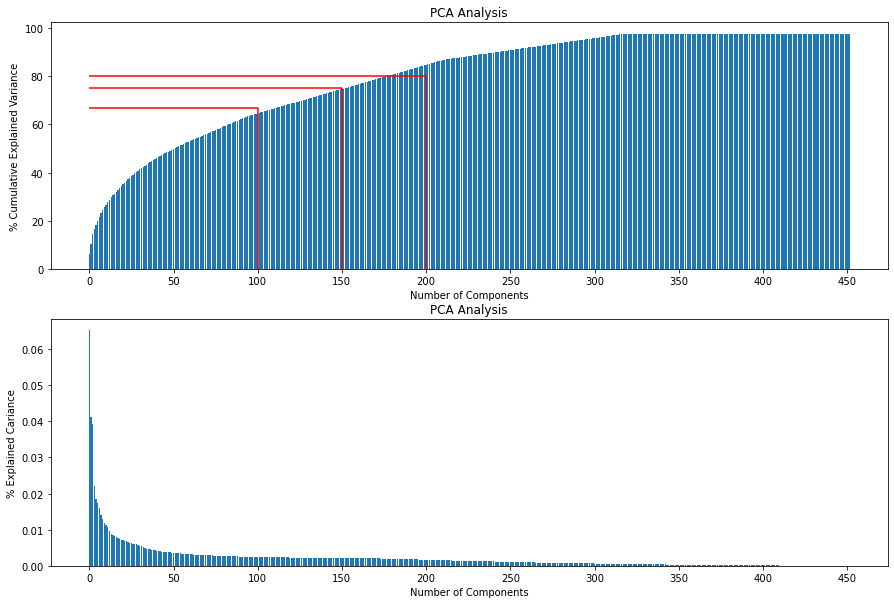

In [50]:
n_components = len(pca.explained_variance_ratio_)
index = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.bar(index, cumsum_variance)
plt.ylabel('% Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.xticks(np.linspace(0,500, 10, endpoint=False))
plt.title('PCA Analysis')

# 100 components
plt.hlines(y=67, xmin=0, xmax=100, color='red', linestyles='-',zorder=1)
plt.vlines(x=100, ymin=0, ymax=67, color='red', linestyles='-',zorder=2)

# 150 components
plt.hlines(y=75, xmin=0, xmax=150, color='red', linestyles='-',zorder=3)
plt.vlines(x=150, ymin=0, ymax=75, color='red', linestyles='-',zorder=4)

# 200 components
plt.hlines(y=80, xmin=0, xmax=200, color='red', linestyles='-',zorder=5)
plt.vlines(x=200, ymin=0, ymax=80, color='red', linestyles='-',zorder=6)

plt.subplot(2, 1, 2)
plt.bar(index, vals)
plt.xticks(np.linspace(0,500, 10, endpoint=False))
plt.xlabel('Number of Components')
plt.ylabel('% Explained Cariance')
plt.title('PCA Analysis');

In [51]:
n_components = 150 # about 75% explained variance
print(f'{n_components}-component has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

150-component has a cumulative explained variane of: 0.7546209063469128


In [52]:
%%time

# re-fitting with n components = 150
pca = PCA(n_components=n_components)

pca_azdias = pca.fit_transform(scaled_azdias)

CPU times: user 1min 16s, sys: 3.19 s, total: 1min 19s
Wall time: 20.9 s


In [53]:
def interpret_pca(df, pca, component):
    '''
    Maps each weight to its corresponding feature name and sorts according to weight.
    Args:
        df (dataframe): dataframe on which pca has been used on.
        pca (pca): pca object.
        component (int): which principal compenent to return
    Returns:
        df_pca (dataframe): dataframe for specified component containing the explained variance
                            and all features and weights sorted according to weight.
    '''
    df_pca = pd.DataFrame(columns=list(df.columns))
    df_pca.loc[0] = pca.components_[component]
    dim_index = "Dimension: {}".format(component + 1)

    df_pca.index = [dim_index]
    df_pca = df_pca.loc[:, df_pca.max().sort_values(ascending=False).index]

    ratio = np.round(pca.explained_variance_ratio_[component], 4)
    df_pca['Explained Variance'] = ratio

    cols = list(df_pca.columns)
    cols = cols[-1:] + cols[:-1]
    df_pca = df_pca[cols]

    return df_pca

In [54]:
# for display purpose

# dim1 = interpret_pca(scaled_azdias, pca, 0)
# with pd.option_context("display.max_rows", 500, "display.max_columns", 1000):
#     display(dim1.T)

## 1.3 Clustering

To date, there are various algorithms that can be applied to divide the general population and customer population into different clusters. A list of 10 of the popular algorithms is as follows:
* Affinity Propagation	
* K-Means
* Spectral Clustering
* Agglomerative Clustering
* Mini-Batch K-Means
* Mixture of Gaussians 
* BIRCH	
* Mean Shift	
* DBSCAN
* OPTICS	

In this project, K-Means clustering is selected since this algorithm is simple and the implementation is not complex. 

### 1.2.1. Develope model

In [55]:
%%time

from sklearn.cluster import KMeans, MiniBatchKMeans

# Number of clusters is from 2 to 25
n_clusters = np.arange(2, 25)

# run K-Means clustering on the data and compute the average within-cluster distances.
scores = [MiniBatchKMeans(i).fit(pca_azdias).score(pca_azdias) for i in n_clusters]

CPU times: user 5min 48s, sys: 10.6 s, total: 5min 59s
Wall time: 1min 12s


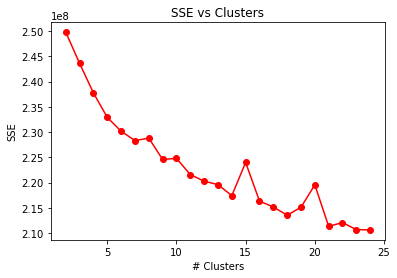

In [56]:
# elbow method
plt.ylabel('SSE')
plt.xlabel('# Clusters')
plt.title('SSE vs Clusters')
plt.plot(n_clusters, np.abs(scores), linestyle='-', marker='o', color='red');

In [57]:
%%time
# re-fith with 12 clusters
kmeans = KMeans(n_clusters=12)

# general population predictions
predicted_azdias = kmeans.fit_predict(pca_azdias)

CPU times: user 9min 47s, sys: 3.4 s, total: 9min 51s
Wall time: 1min 4s


In [58]:
import joblib

joblib.dump(scaler, 'cache/scaler.save')
joblib.dump(pca, 'cache/pca.save')
joblib.dump(kmeans, 'cache/kmeans.save')

print('Parameters saved in cache!')

Parameters saved in cache!


### 1.2.2. Clustering

In [3]:
### load pkl files if restarting the kernel
cleaned_azdias = pd.read_pickle('data/cleaned_azdias.pkl')
print(cleaned_azdias.shape)

cleaned_customers = pd.read_pickle('data/cleaned_customers.pkl')
print(cleaned_customers.shape)

(785300, 452)
(140355, 452)


In [60]:
import joblib

### load the saved parameters if restarting the kernel
scaler = joblib.load('cache/scaler.save')
pca = joblib.load('cache/pca.save')
kmeans = joblib.load('cache/kmeans.save')

print('Successfully loaded parameters!')

Successfully loaded parameters!


In [61]:
def clusters_predict(df, scaler, pca, kmeans):
    '''
    Applies scaler, pca and predicts clusters on a cleaned dataset.
    '''
    LNR = np.zeros(df.shape[0])
    if 'LNR' in df.columns:
        LNR = df['LNR'].values
        df.drop(['LNR'], axis=1, inplace=True)

    df_scaled = scaler.transform(df.astype('float'))
    df_pca = pca.transform(df_scaled)
    df_preds = kmeans.predict(df_pca)

    df_clusters = pd.DataFrame({'LNR': LNR, 'Clusters': df_preds})

    return df_clusters

In [62]:
# predict clusters
azdias_preds = clusters_predict(cleaned_azdias, scaler, pca, kmeans)
customers_preds = clusters_predict(cleaned_customers, scaler, pca, kmeans)

In [63]:
from collections import Counter

# count individual by cluster
azdias_proportions = Counter(azdias_preds['Clusters'])
customers_proportions = Counter(customers_preds['Clusters'])

# get proportion by cluster
len_azdias = cleaned_azdias.shape[0]
len_customers = cleaned_customers.shape[0]

for idx, num in azdias_proportions.items():
    azdias_proportions[idx] = num / len_azdias
    
for idx, num in customers_proportions.items():
    customers_proportions[idx] = num / len_customers

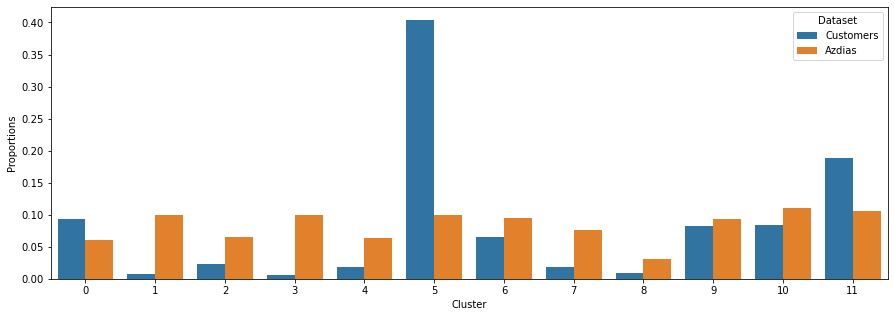

In [64]:
# display proportion
df_props = pd.DataFrame(columns=["Dataset", "Cluster", "Proportions", 'Difference'])

for idx, prop in customers_proportions.items():
    df_props = df_props.append({"Dataset" : "Customers", "Cluster": idx, "Proportions": prop}, ignore_index=True)

for idx, prop in azdias_proportions.items():
    df_props = df_props.append({"Dataset" : "Azdias", "Cluster": idx, "Proportions": prop}, ignore_index=True)

fig = plt.figure(figsize=(15,5))
sns.barplot(x="Cluster", y="Proportions", hue="Dataset", data=df_props);

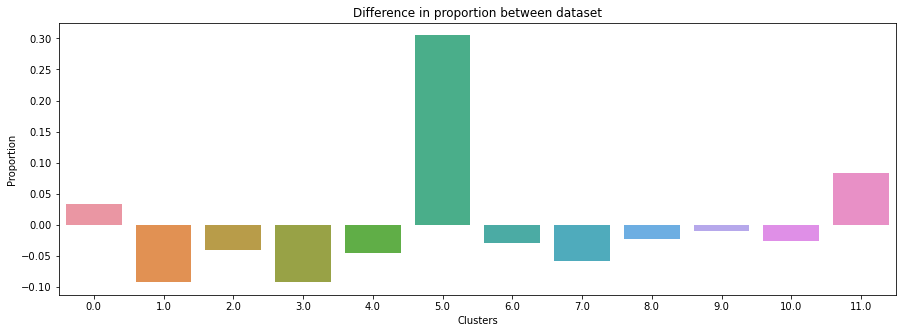

In [65]:
df_difference = pd.DataFrame(columns=['Cluster', 'Difference'])

for idx, azdias_props in azdias_proportions.items():
    diff = customers_proportions[idx] - azdias_props
    df_difference = df_difference.append({"Cluster": idx, "Difference": diff}, ignore_index=True)

fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x = df_difference['Cluster'], y = df_difference['Difference'])
ax.set(title=f'Difference in proportion between dataset', ylabel='Proportion', xlabel='Clusters');

In [66]:
target_cluster = 5
general_cluster = 1

## 1.3. Analysis

We look at the distribution of the two clusters to find out the common characteristics of target group and general group (i.e. the group with less individual that potentially become new customers)

Analyzing  all attributes is an exhausted task. For learning purpose, we can pick some attributes of which the distribution trend is clearly distinguished
 * HH_EINKOMMEN_SCORE: estimated household_net_income 
 * ALTERSKATEGORIE_GROB: age classification through prename analysis 
 * GENERATION_DECADE: separated from PRAEGENDE_JUGENDJAHRE 
 * FINANZ_SPARER: financial typology: money saver
 * MOBI_REGIO: moving patterns
 * LP_STATUS_GROB: social status rough

In [67]:
# get predictions
df_preds_azdias = pd.DataFrame(azdias_preds['Clusters'].values, columns = ['Cluster'])
df_preds_customers = pd.DataFrame(customers_preds['Clusters'].values, columns = ['Cluster'])

In [68]:
target_customers = df_preds_customers[df_preds_customers['Cluster'] == target_cluster].index
general_azdias = df_preds_azdias[df_preds_azdias['Cluster'] == general_cluster].index

df_target_customers = cleaned_customers.iloc[target_customers]
df_general_azdias = cleaned_azdias.iloc[general_azdias]

In [70]:
def plot_comparison(column, df_target_customers, df_general_azdias, clusters=[8,12]):
    '''
    Plots the distribution for a feature.
    
    Args:
        column (string) - feature to plot.
        df_target_customers (dataframe) - customer population cluster.
        df_general_azdias (dataframe) - general population cluster.
        clusters (list) - ints to use when pritting out title.
    '''   
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x=column, data=df_target_customers, ax=ax1, palette="Set2")
    ax1.set_xlabel('Value')
    ax1.set_title(f'Distribution of Customers (cluster: {clusters[0]})')
    sns.countplot(x=column, data=df_general_azdias, ax=ax2, palette="Set2")
    ax2.set_xlabel('Value')
    ax2.set_title(f'Distribution of Azdias (cluster: {clusters[1]})')
    fig.suptitle(f'Feature: {column}')
    
    print('Mean of customers: ', sum(df_target_customers[column])/len(df_target_customers[column]))
    print('Mean of azdias   : ', sum(df_general_azdias[column])/len(df_general_azdias[column]))

Mean of customers:  2.2144885611980314
Mean of azdias   :  4.51022592606751


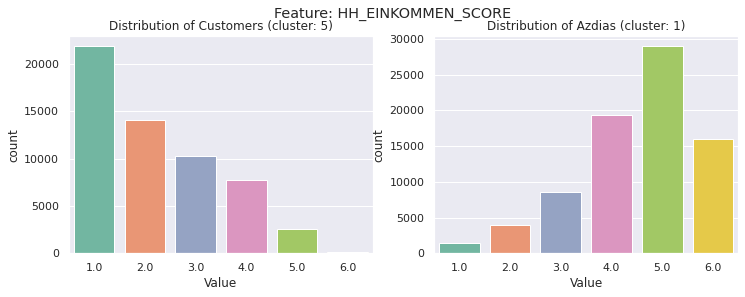

In [73]:
### Finding #1: Target customers likely have high net income
plot_comparison('HH_EINKOMMEN_SCORE', df_target_customers, df_general_azdias, [target_cluster, general_cluster])

Mean of customers:  3.6285432063923238
Mean of azdias   :  1.9325662295959325


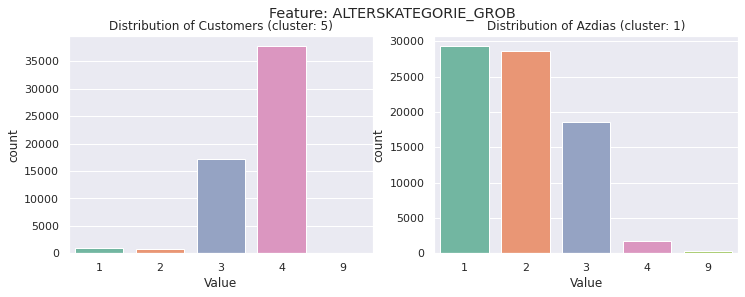

In [77]:
### Finding #2: Target customers are almost 46 years old or even higher
plot_comparison('ALTERSKATEGORIE_GROB', df_target_customers, df_general_azdias, [target_cluster, general_cluster])

Mean of customers:  1.1786993103204981
Mean of azdias   :  4.124928322948125


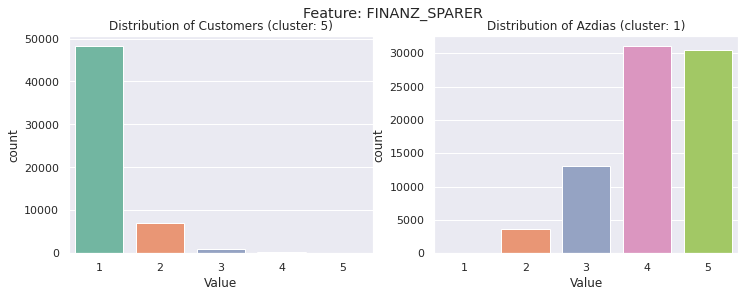

In [78]:
### Finding #3: Target customers are potentially money saver
plot_comparison('FINANZ_SPARER', df_target_customers, df_general_azdias, [target_cluster, general_cluster])

Mean of customers:  5.557511509357417
Mean of azdias   :  8.702932069268703


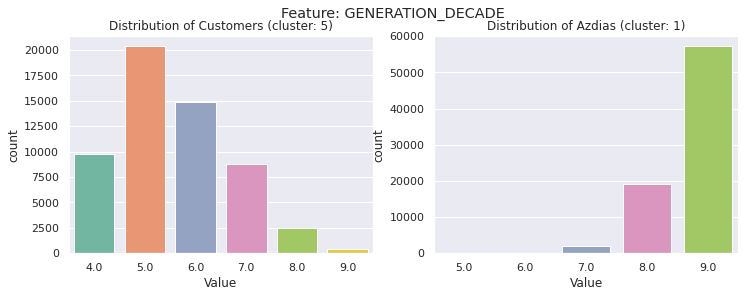

In [79]:
### Cannot found any thing here because the number of unknown value (i.e. 9) in Azdias distribution is high ~50000
### As for customers, it is clear that their youths are in 50, 60ies
plot_comparison('GENERATION_DECADE', df_target_customers, df_general_azdias, [target_cluster, general_cluster])

Mean of customers:  4.221438272802639
Mean of azdias   :  3.3494909336493497


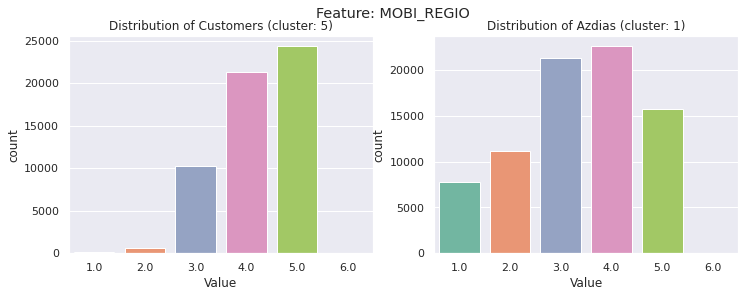

In [81]:
### Finding #4: Target customers have lower moving patterns
plot_comparison('MOBI_REGIO', df_target_customers, df_general_azdias, [target_cluster, general_cluster])

Mean of customers:  0.00336902263065987
Mean of azdias   :  0.3501917759343502
Mean of customers:  0.7819483886899617
Mean of azdias   :  0.053276756247053275


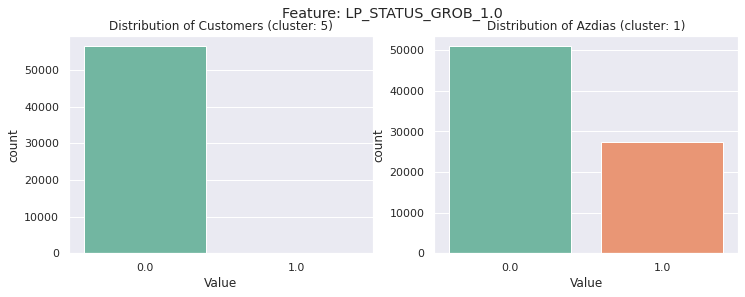

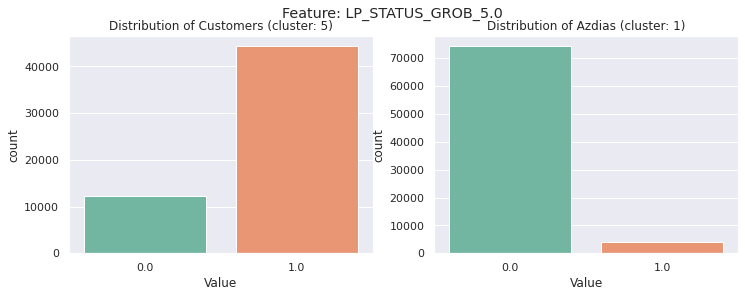

In [82]:
### Finding #5: Target customers are top earners in terms of social status
plot_comparison('LP_STATUS_GROB_1.0', df_target_customers, df_general_azdias, [target_cluster, general_cluster])
plot_comparison('LP_STATUS_GROB_5.0', df_target_customers, df_general_azdias, [target_cluster, general_cluster])

## Part 2: Supervised Learning Model for Customer Predictions

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [83]:
# load the third and fourth datasets (for campaign)
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

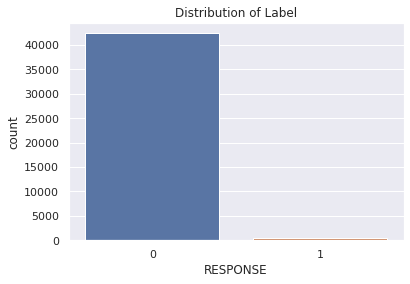

In [84]:
# get labels
label = mailout_train['RESPONSE']
mailout_train_dropped = mailout_train.drop('RESPONSE', axis=1)

# there is a large label imbalance
sns.countplot(label).set_title("Distribution of Label");

## 2.0. Data processing

In [85]:
# data cleaning (except re-encoding)
mailout_train_cleaned = clean_dataset(mailout_train_dropped, drop_rows = False)
print('Training set\'s shape after data cleaning: ',mailout_train_cleaned.shape)
print('=====================================================')

mailout_test_cleaned = clean_dataset(mailout_test, drop_rows = False)
print('Test set \'s shape after data cleaning: ',mailout_test_cleaned .shape)

===== Drop extra columns =====
======== Drop columns ========
(42962, 288)
==== Handle Unknown value ====
(42962, 288)
======== Modify data =========
(42962, 290)
=========== Impute ===========


[========================================================================] 100%


(42962, 290)
Training set's shape after data cleaning:  (42962, 290)
===== Drop extra columns =====
======== Drop columns ========
(42833, 288)
==== Handle Unknown value ====
(42833, 288)
======== Modify data =========


(42833, 290)
=========== Impute ===========


(42833, 290)
Test set 's shape after data cleaning:  (42833, 290)


In [86]:
from sklearn.preprocessing import OneHotEncoder

# apply one-hot re-encoder
OH_encoder = joblib.load('cache/OH_encoder.save')

cat_features = ['WOHNLAGE', 'ZABEOTYP', 'CJT_KATALOGNUTZER', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_HERSTTEMP', 
                'STRUKTURTYP', 'LP_LEBENSPHASE_GROB', 'CJT_GESAMTTYP', 'SHOPPER_TYP', 'GEBAEUDETYP', 
                'D19_KONSUMTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'KBA05_MAXHERST', 'PLZ8_BAUMAX', 'HEALTH_TYP', 
                'RETOURTYP_BK_S', 'VHA', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 
                'KBA05_MAXSEG', 'LP_STATUS_GROB', 'NATIONALITAET_KZ']

mailout_train_cleaned  = transform(mailout_train_cleaned, cat_features, OH_encoder)
mailout_test_cleaned  = transform(mailout_test_cleaned, cat_features, OH_encoder)

print('Training set\'s shape after data processing: ',mailout_train_cleaned.shape)
print('Test set \'s shape after data processing:    ',mailout_test_cleaned .shape)

Training set's shape after data processing:  (42962, 452)
Test set 's shape after data processing:     (42833, 452)


In [88]:
from sklearn.preprocessing import StandardScaler

# apply Standard Scaler (must be similar to Customer Segmentation)
scaler = StandardScaler()
scaler.fit_transform(mailout_train_cleaned.astype('float'))

mailout_train_cleaned_scaled = scaler.transform(mailout_train_cleaned)
mailout_test_cleaned_scaled = scaler.transform(mailout_test_cleaned)

mailout_train_cleaned_scaled = pd.DataFrame(data=mailout_train_cleaned_scaled, columns=mailout_train_cleaned.columns)
mailout_test_cleaned_scaled = pd.DataFrame(data=mailout_test_cleaned_scaled, columns=mailout_test_cleaned.columns)

print('Training set\'s shape after scaling: ',mailout_train_cleaned_scaled.shape)
print('Test set\'s shape after scaling:    ',mailout_test_cleaned_scaled.shape)

Training set's shape after scaling:  (42962, 452)
Test set's shape after scaling:     (42833, 452)


In [89]:
# save the proceeded datasets
mailout_train_cleaned_scaled.to_pickle('data/mailout_train_cleaned_scaled.pkl')
mailout_test_cleaned_scaled.to_pickle('data/mailout_test_cleaned_scaled.pkl')

## 2.1. Examine supervised learning algorithms with default settings

In [90]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

import xgboost as xgb
import lightgbm as lgb

In [91]:
# load the proceeded datasets
mailout_train_cleaned_scaled = pd.read_pickle('data/mailout_train_cleaned_scaled.pkl')
mailout_test_cleaned_scaled = pd.read_pickle('data/mailout_test_cleaned_scaled.pkl')

In [92]:
# same setting for random_state
SEED = 30

In [93]:
### stratified K-Folds cross-validator with K = 5
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
skf.get_n_splits(mailout_train_cleaned_scaled, label)

5

In [94]:
def get_base_models():
    '''
    Get 6 models with default settings
    '''
    basedModels = []
    basedModels.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
    basedModels.append(('RF', RandomForestClassifier(random_state=SEED)))
    basedModels.append(('XGB', xgb.XGBClassifier(random_state=SEED)))
    basedModels.append(('LGBM', lgb.LGBMClassifier(random_state=SEED)))
    basedModels.append(('GB', GradientBoostingClassifier(random_state=SEED)))
    basedModels.append(('MLP', MLPClassifier(random_state=SEED)))
    
    return basedModels

In [95]:
def evaluate(features, label, models, curve=False):
    '''
    Evaluate models using K-Fold cross-validation and plot learning curve (optional).
    
    Input:
        features (dataframe) - dataset to be used for training.
        label (dataframe) - target variable
        models (list) - list of models to be evaluated.
        curve (bool) - whether or not to plot learning curve.

    Output:
        names (list) - list of models tested.
        results (list) - list of results for each model.
    '''
    results = []
    names = []
    for name, model in models:
        # evaluate a score by cross-validation 
        result = cross_val_score(model, features, label, cv=skf, scoring='roc_auc', n_jobs=-1)
        msg = "%s: %f (std: %f)" % (name, result.mean(), result.std())
        print(msg)
        
        # append result to list
        results.append(result)
        names.append(name)
        
        # plot result
        if curve:
            train_sizes, train_scores, test_scores = learning_curve(model, features, label, cv=skf, scoring = 'roc_auc', 
                                                                    train_sizes=np.linspace(.1, 1.0, 10), n_jobs=-1)

            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            print("ROC-AUC train score = {}".format(train_scores_mean[-1].round(2)))
            print("ROC-AUC validation score = {}".format(test_scores_mean[-1].round(2)))
            
            plt.grid()
            plt.title("Learning Curve")
            plt.xlabel("Percent of training set")
            plt.ylabel("Score")
            plt.plot(np.linspace(.1, 1.0, 10)*100, train_scores_mean, 'o-.', color="b", label="Training score")
            plt.plot(np.linspace(.1, 1.0, 10)*100, test_scores_mean, 'x-', color="r", label="Validation score")

            plt.yticks(np.arange(0.50, 1.00, 0.05)) # only from 45% to 100%
            plt.xticks(np.arange(0., 100.05, 10)) # 10 points from 10% to 100% 
            plt.legend(loc="best")
            print("")
            plt.show()
        
    return names, results

In [96]:
def dec2float(value, dec=4):
    template = "{:."+str(dec)+"f}" 
    return float(template.format(value))

LR: 0.640895 (std: 0.020584)
ROC-AUC train score = 0.82
ROC-AUC validation score = 0.64



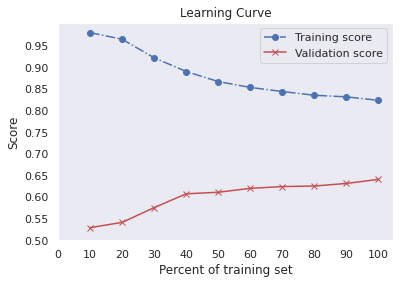

RF: 0.577167 (std: 0.031954)
ROC-AUC train score = 0.97
ROC-AUC validation score = 0.58



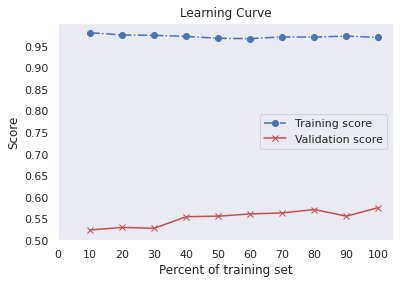

XGB: 0.678916 (std: 0.028972)
ROC-AUC train score = 0.99
ROC-AUC validation score = 0.68



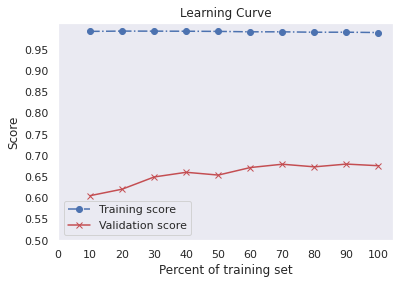

LGBM: 0.710863 (std: 0.023605)


/home/hung/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


ROC-AUC train score = 0.98
ROC-AUC validation score = 0.71



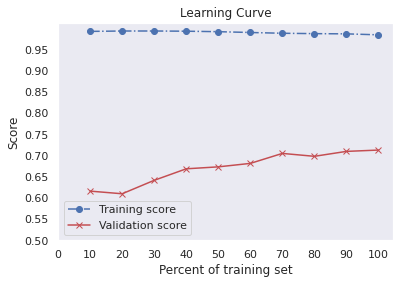

GB: 0.753174 (std: 0.021035)
ROC-AUC train score = 0.91
ROC-AUC validation score = 0.75



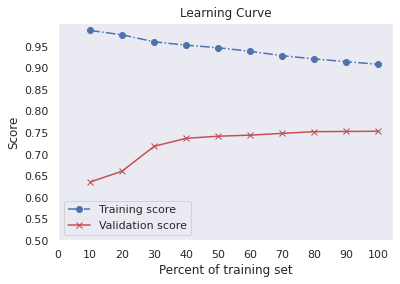

MLP: 0.596191 (std: 0.022477)
ROC-AUC train score = 0.99
ROC-AUC validation score = 0.6



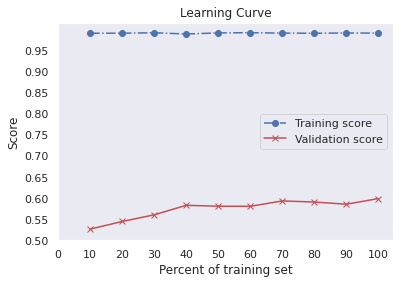

,Model,Score
0,LR,0.6409
1,RF,0.5772
2,XGB,0.6789
3,LGBM,0.7109
4,GB,0.7532
5,MLP,0.5962


In [97]:
# evaluate and plot result
models = get_base_models()
model_names, results = evaluate(mailout_train_cleaned_scaled, label, models, curve=True)

# summary
def dec2float(value, dec=4):
    template = "{:."+str(dec)+"f}" 
    return float(template.format(value))

model_scores = [dec2float(result.mean()) for result in results]
baseline_score = pd.DataFrame({'Model':model_names, 'Score': model_scores})

baseline_score #display dataframe contains baseline score

## 2.2. Refinement

Given one result, we cannot augue that which method is better. In this project, GB method is used.

For parameter tuning, we can use random search to find the optimal set of hyperparameters. Compared to the grid search, this search method is comparatively less costly and more effective. As fully understanding all hyperparameters are out of the scope of this project, the main four parameters to do tuning includes: n_estimators, learning_rate, subsample, and max_depth. 

In [98]:
from scipy import stats

# define models and parameters
gb_model = GradientBoostingClassifier()

# define models and parameters
parameters = {
    'n_estimators' : stats.randint(50, 500),
    'learning_rate': stats.loguniform(0.001, 1.0), # (0.001, 1.0, 'log-uniform'),
    'subsample'    : stats.uniform(0.5, 1.0),
    'max_depth'    : stats.randint(4, 10)
}

# define cross-validation generator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [99]:
from sklearn.model_selection import RandomizedSearchCV

# setup parameters
random_search = RandomizedSearchCV(
    estimator = gb_model, 
    param_distributions = parameters, 
    cv = skf, 
    n_iter = 20, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=0
)

In [100]:
%%time
random_search.fit(mailout_train_cleaned_scaled, label)

CPU times: user 58.7 s, sys: 1.27 s, total: 60 s
Wall time: 24min 29s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
                   estimator=GradientBoostingClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c683518d0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c68398bd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c6839ff50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c68398710>},
                   scoring='roc_auc')

In [101]:
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best score:')
print(random_search.best_score_ )


 Best estimator:
GradientBoostingClassifier(learning_rate=0.01198968914398581, max_depth=5,
                           n_estimators=119, subsample=0.6648638098977245)

 Best score:
0.7594234654457788


In [104]:
import joblib
joblib.dump(best_model, 'model/best_model.save')

['model/best_model.save']

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [105]:
best_model.fit(mailout_train_cleaned_scaled, label)

GradientBoostingClassifier(learning_rate=0.01198968914398581, max_depth=5,
                           n_estimators=119, subsample=0.6648638098977245)

In [106]:
preds = best_model.predict_proba(mailout_test_cleaned_scaled)[:,1]

In [107]:
# create submission file
kaggle_sub = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=preds)
kaggle_sub.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_sub.head()

,RESPONSE
LNR,
1754,0.025242
1770,0.027501
1465,0.005243
1470,0.007233
1478,0.006807


In [108]:
kaggle_sub.to_csv('kaggle_submission.csv')